In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats as st
import copy

The aim of this notebook is to demonstrate the effect that different types of outliers can have on the slope of the fitted linear model. We can distinguish three types of outliers:

- A high leverage point is an observation that is horizontally distant with respect to the rest of observations. A high leverage point may or may not have a big impact on the slope of the fitted linear model.
- An influential point is a leverage point that has a big impact on the slope of the linear model
- Finally, we can have outliers that are neigher high leverage nor influential points.

In [2]:
SIZE = 25
def generate_random_linear_sample(slope, intercept, noise_std, x_init, x_end):
    x = np.random.uniform(x_init, x_end, SIZE)
    y = x*slope + intercept + np.random.normal(0, noise_std, SIZE)
    
    return (x,y)

In [3]:
SLOPE = -1.23
INTERCEPT = 5
NOISE_STD = 5
x, y = generate_random_linear_sample(SLOPE, INTERCEPT, NOISE_STD, 20, 80)

### No outliers

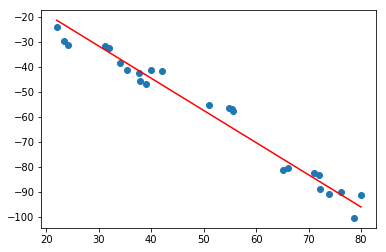

In [4]:
def fit(x, y):
    R = 1/(len(x) - 1)*np.sum((x - np.mean(x))*(y - np.mean(y))/(np.std(x) * np.std(y)))
    b1 = R * np.std(y) / np.std(x)
    b0 = np.mean(y) - b1 * np.mean(x)
    return(R, b1, b0)

def predict(x, b0, b1):
    return(b0 + b1*x)

fig, ax = plt.subplots()
ax.scatter(x, y)
(R, b1, b0) = fit(x,y)
ax.plot([np.min(x), np.max(x)], [predict(np.min(x), b0, b1), predict(np.max(x), b0, b1)], 'r')

### High leverage (non-influential) point

This kind of outlier does not have a big impact on the slope of the fitted linear model. The continuous line represents the linear model fitted from the original dataset (without outliers). The dashed line represents the linear model fitted from the dataset after adding the outlier.

In [5]:
x_c = copy.deepcopy(x)
y_c = copy.deepcopy(y)

x_c = np.append(x_c, 120)
y_c = np.append(y_c, 120*SLOPE + INTERCEPT + np.random.normal(0, 0, 1))

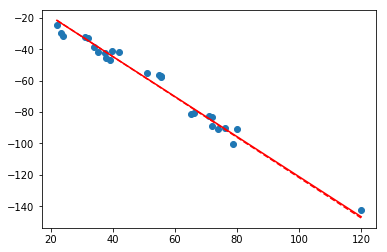

In [6]:
(R_c, b1_c, b0_c) = fit(x_c, y_c)

fig, ax = plt.subplots()
ax.scatter(x_c, y_c)
ax.plot([np.min(x_c), np.max(x_c)], [predict(np.min(x_c), b0, b1), predict(np.max(x_c), b0, b1)], 'r--')
ax.plot([np.min(x_c), np.max(x_c)], [predict(np.min(x_c), b0_c, b1_c), predict(np.max(x_c), b0_c, b1_c)], 'r')

### Influential point

This kind of outlier has a big impact on th eslope of the fitted linear model.The continuous line represents the linear model fitted from the original dataset (without outliers). The dashed line represents the linear model fitted from the dataset after adding the outlier.

In [7]:
x_c = copy.deepcopy(x)
y_c = copy.deepcopy(y)

x_c = np.append(x_c, 120)
y_c = np.append(y_c, 120*SLOPE + INTERCEPT + 20)

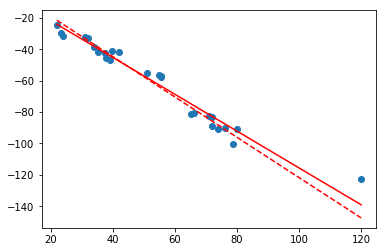

In [8]:
(R_c, b1_c, b0_c) = fit(x_c, y_c)

fig, ax = plt.subplots()
ax.scatter(x_c, y_c)
ax.plot([np.min(x_c), np.max(x_c)], [predict(np.min(x_c), b0, b1), predict(np.max(x_c), b0, b1)], 'r--')
ax.plot([np.min(x_c), np.max(x_c)], [predict(np.min(x_c), b0_c, b1_c), predict(np.max(x_c), b0_c, b1_c)], 'r')

Cook's distance is a measure of how influential a point is. The cook distance Di of an observation i is calculated as the sum of differences caused by removing such observation from the sample. The following code demonstrates that the (120, -122.6) is an influential point, whose influence is much higher than the second most influential point.

In [9]:
def calculate_cook_distance(x_c, y_c, b0_c, b1_c):
    D = []

    predict_c = predict(x_c, b0_c, b1_c)
    p = 2 # The linear model has only two parameters (intercept and slope)
    mse = (np.sum((predict_c - y_c)**2))/x_c.shape[0] # mean squared error

    for i in range(x_c.shape[0]):
        x_c_i = copy.deepcopy(x_c)
        y_c_i = copy.deepcopy(y_c)
        x_c_i = np.delete(x_c_i, i)
        y_c_i = np.delete(y_c_i, i)

        (R_c_i, b1_c_i, b0_c_i) = fit(x_c_i, y_c_i)

        predict_c_i = predict(x_c_i, b0_c_i, b1_c_i)
        predict_c_i = np.insert(predict_c_i, i, predict_c[i])

        D.append(np.sum((predict_c - predict_c_i)**2) / (p*mse))

    df = pd.DataFrame(np.array([x_c, y_c, D]).T, columns = ['x', 'y', 'D'])    
    df = df.sort_values(by='D', ascending=False)
    
    return df

calculate_cook_distance(x_c, y_c, b0_c, b1_c)

,x,y,D
25,120.000000,-122.600000,2.071696
11,78.614948,-100.367623,0.167976
18,73.867476,-91.022579,0.047786
0,24.097023,-31.257498,0.039748
21,72.109551,-88.707637,0.039275
17,65.149726,-81.291158,0.035244
24,55.479472,-56.765354,0.031436
15,23.341898,-29.597636,0.027363
20,54.893142,-56.542903,0.026953
3,42.095816,-41.778538,0.026940


### Non-high leverage point

This outlier has some effect on the slope, but not as much as the influential point in the previous example. This is also demonstrated by the Cook's distance values. 

In [10]:
x_c = copy.deepcopy(x)
y_c = copy.deepcopy(y)

x_c = np.append(x_c, 65)
y_c = np.append(y_c, 65*SLOPE + INTERCEPT + 20)

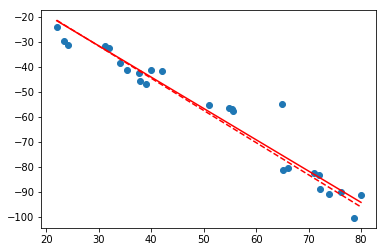

In [11]:
(R_c, b1_c, b0_c) = fit(x_c, y_c)

fig, ax = plt.subplots()
ax.scatter(x_c, y_c)
ax.plot([np.min(x_c), np.max(x_c)], [predict(np.min(x_c), b0, b1), predict(np.max(x_c), b0, b1)], 'r--')
ax.plot([np.min(x_c), np.max(x_c)], [predict(np.min(x_c), b0_c, b1_c), predict(np.max(x_c), b0_c, b1_c)], 'r')

In [12]:
calculate_cook_distance(x_c, y_c, b0_c, b1_c)

,x,y,D
25,65.000000,-54.950000,0.406866
11,78.614948,-100.367623,0.152518
0,24.097023,-31.257498,0.088735
15,23.341898,-29.597636,0.072079
18,73.867476,-91.022579,0.036246
24,55.479472,-56.765354,0.030539
21,72.109551,-88.707637,0.029602
17,65.149726,-81.291158,0.028663
20,54.893142,-56.542903,0.025762
2,55.509002,-57.793488,0.022611
